In [6]:
from typing import TypedDict, Annotated
from langgraph.graph import START, END, StateGraph
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)

In [8]:
class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node1(state: OverallState) -> PrivateState:
    print('---- NODE 1 ----')
    return {'baz': state['foo']+1}

def node2(state: PrivateState) -> OverallState:
    print('---- NODE 2 ----')
    return {'foo': state['baz']+1}

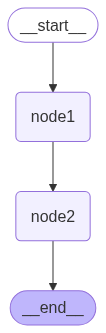

In [10]:
from langgraph.checkpoint.memory import MemorySaver
config = {'configurable': {'thread_id':1}}
builder = StateGraph(OverallState)
builder.add_node('node1', node1)
builder.add_node('node2', node2)

# Logic
builder.add_edge(START, 'node1')
builder.add_edge('node1', 'node2')
builder.add_edge('node2', END)

graph = builder.compile(checkpointer = MemorySaver())
graph 

In [11]:
graph.invoke({'foo': 1},config)

---- NODE 1 ----
---- NODE 2 ----


{'foo': 3}

### Input/ Output state

In [13]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState) -> OverallState:
    return {'answer': 'bye', 'notes': '... his name is Utkarsh'}

def answer_node(state: OverallState) -> OutputState:
    return {'answer': 'bye Utkarsh'}
# Overallstate = the overall state graph will track
# Inputstate = the subset of overall state that user can send as input
# Outputstate = the subset of overall state that graph will send as output
graph = StateGraph(OverallState, input=InputState, output = OutputState)